# 🌟 Cryptocurrency Volatility Prediction and Portfolio Strategy 📈

---

## 🚀 Project Overview

This notebook focuses on the analysis, prediction, and optimization of cryptocurrency market behavior.  
 Here's the roadmap:

---

### **1️⃣ Data Collection**: 📊 **Scraping Cryptocurrency Data** 
We begin by **scraping price data** for cryptocurrencies from **Yahoo Finance** to build our dataset. For this purpose, we’ll use the **BeautifulSoup** library to efficiently extract and organize the data. The cryptocurrencies we will focus on are:
- **Bitcoin (BTC)** 🪙
- **Ethereum (ETH)** 🔷
- **Litecoin (LTC)** 💡
---

### **2️⃣ Volatility Prediction**: 🤖 **Optimized Neural Networks**
Harnessing the power of **machine learning**, we'll predict cryptocurrency volatility with a cutting-edge approach:
- Craft **custom features** to better understand market dynamics.
- Compare and optimize **neural network architectures** to find the most effective model for volatility prediction.

---

### **3️⃣ Portfolio Strategy Development**: 💼 **Smart Investments**
With volatility insights in hand, we'll develop and evaluate portfolio strategies, such as:
- **Risk Parity** allocation and other advanced techniques.
- Perform a side-by-side comparison of these strategies to identify the **optimal approach**.

---

### **4️⃣ Object-Oriented Design**: 🛠️ **Python-Powered**
All components will be designed using a **modular, package-oriented approach** in Python:
- Reusable **classes** and **objects** for clean, efficient, and scalable code.
- A focus on maintainable and professional software design.

---

## 🎯 Goals and Outcomes
- Build an **end-to-end cryptocurrency analysis pipeline**.
- Leverage **AI and neural networks** to predict market behavior.
- Construct and compare **portfolio allocation strategies** to maximize returns and manage risk effectively.

Let’s dive into the fascinating world of cryptocurrencies and uncover innovative solutions for navigating this ever-evolving market! 🌐✨

---


In [1]:
import sys
from datetime import datetime

import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import numpy as np
import pandas as pd

from crypto_volatility_lab.data_construction import CryptoScraper, FeaturesCreator, TimeSeriesCreator
from crypto_volatility_lab.modeling import GRUPipeline, LSTMPipeline, LSTMGRUPipeline, TCNNPipeline
from crypto_volatility_lab.portfolio_optimization.portfolioConstructor import PortfolioConstructor

sys.path.append("crypto-volatility-lab")
plt.style.use("seaborn-v0_8-darkgrid")

In [2]:
# Important constants
currency_list = ['BTC-USD', 'ETH-USD', 'LTC-USD']
test_start_date = datetime.strptime('2024-01-01', "%Y-%m-%d")

### **Data Collection**: 📊 **Scraping Cryptocurrency Data** 

We will scrape historical data for **Bitcoin (BTC)**, **Ethereum (ETH)**, and **Litecoin (LTC)** from **Yahoo Finance**, covering all available history up to today.

The `CryptoScraper` simplifies fetching historical cryptocurrency data from Yahoo Finance. It automates data retrieval, cleaning, and structuring into a **Pandas DataFrame**, making it ready for analysis.


#### **Key Features**
1. **Customizable Date Range**:
   - `start_date`: Start of data collection (default: earliest available).
   - `end_date`: End of data collection (default: tomorrow).
2. **Flexible Setup**:
   - Uses `BeautifulSoup` for HTML parsing and `DEFAULT_HEADERS` to ensure smooth web requests.
3. **Clean Output**:
   - Returns structured data with parsed dates and numeric columns for prices and volume.

---

In [3]:
crypto_scraper = CryptoScraper()

bitcoin_data = crypto_scraper.get_data_for_currency('BTC-USD')
ethereum_data = crypto_scraper.get_data_for_currency('ETH-USD')
litecoin_data = crypto_scraper.get_data_for_currency('LTC-USD')

# Data example
bitcoin_data.head()

,Date,Open,High,Low,Close,Adj,Volume
0,2025-01-29,101287.84,102902.67,101287.84,102822.56,102822.56,38001197056
1,2025-01-28,102095.41,103730.82,100238.19,101332.48,101332.48,47180685494
2,2025-01-27,102680.30,103214.11,97795.94,102087.69,102087.69,89006608428
3,2025-01-26,104713.21,105438.65,102507.71,102682.50,102682.50,22543395879
4,2025-01-25,104824.03,105243.79,104120.38,104714.65,104714.65,23888996502


### **📈 Creating Time Series of Log Returns and Volatility**

We will generate time series for **log returns** and **volatility** for the three cryptocurrencies (**Bitcoin, Ethereum, Litecoin**) using the `TimeSeriesCreator` object. These time series will serve as the foundation for our analysis and modeling.

---

**What the `TimeSeriesCreator` Does**
1. **Log Returns**: Calculates the log returns from the closing price data, capturing percentage changes in price on a logarithmic scale.
2. **Volatility**: Computes rolling volatility (standard deviation) of log returns over a specified window size (default: 21 days).

Note: We need to drop `NaN` values from the resulting time series because the calculation of log returns and rolling volatility inherently produces missing values at the beginning (e.g., the first log return and the initial rolling window). 


In [4]:
ts_creator = TimeSeriesCreator(data=bitcoin_data, date_column_name='Date', value_column_name='Close')
bitcoin_data["Log Returns"] = ts_creator.create_log_return_time_series()
bitcoin_data["Volatility"] = ts_creator.create_volatility_time_series()
bitcoin_data.dropna(inplace=True)


ts_creator = TimeSeriesCreator(data=ethereum_data, date_column_name='Date', value_column_name='Close')
ethereum_data["Log Returns"] = ts_creator.create_log_return_time_series()
ethereum_data["Volatility"] = ts_creator.create_volatility_time_series()
ethereum_data.dropna(inplace=True)

ts_creator = TimeSeriesCreator(data=litecoin_data, date_column_name='Date', value_column_name='Close')
litecoin_data["Log Returns"] = ts_creator.create_log_return_time_series()
litecoin_data["Volatility"] = ts_creator.create_volatility_time_series()
litecoin_data.dropna(inplace=True)

# Data example
bitcoin_data.head()

,Date,Open,High,Low,Close,Adj,Volume,Log Returns,Volatility
3766,2014-10-08,336.12,354.36,327.19,352.94,352.94,54736300,0.048622,0.042931
3765,2014-10-09,352.75,382.73,347.69,365.03,365.03,83641104,0.033681,0.041557
3764,2014-10-10,364.69,375.07,352.96,361.56,361.56,43665700,-0.009552,0.038797
3763,2014-10-11,361.36,367.19,355.95,362.30,362.30,13345200,0.002045,0.037781
3762,2014-10-12,362.61,379.43,356.14,378.55,378.55,17552800,0.043876,0.038999


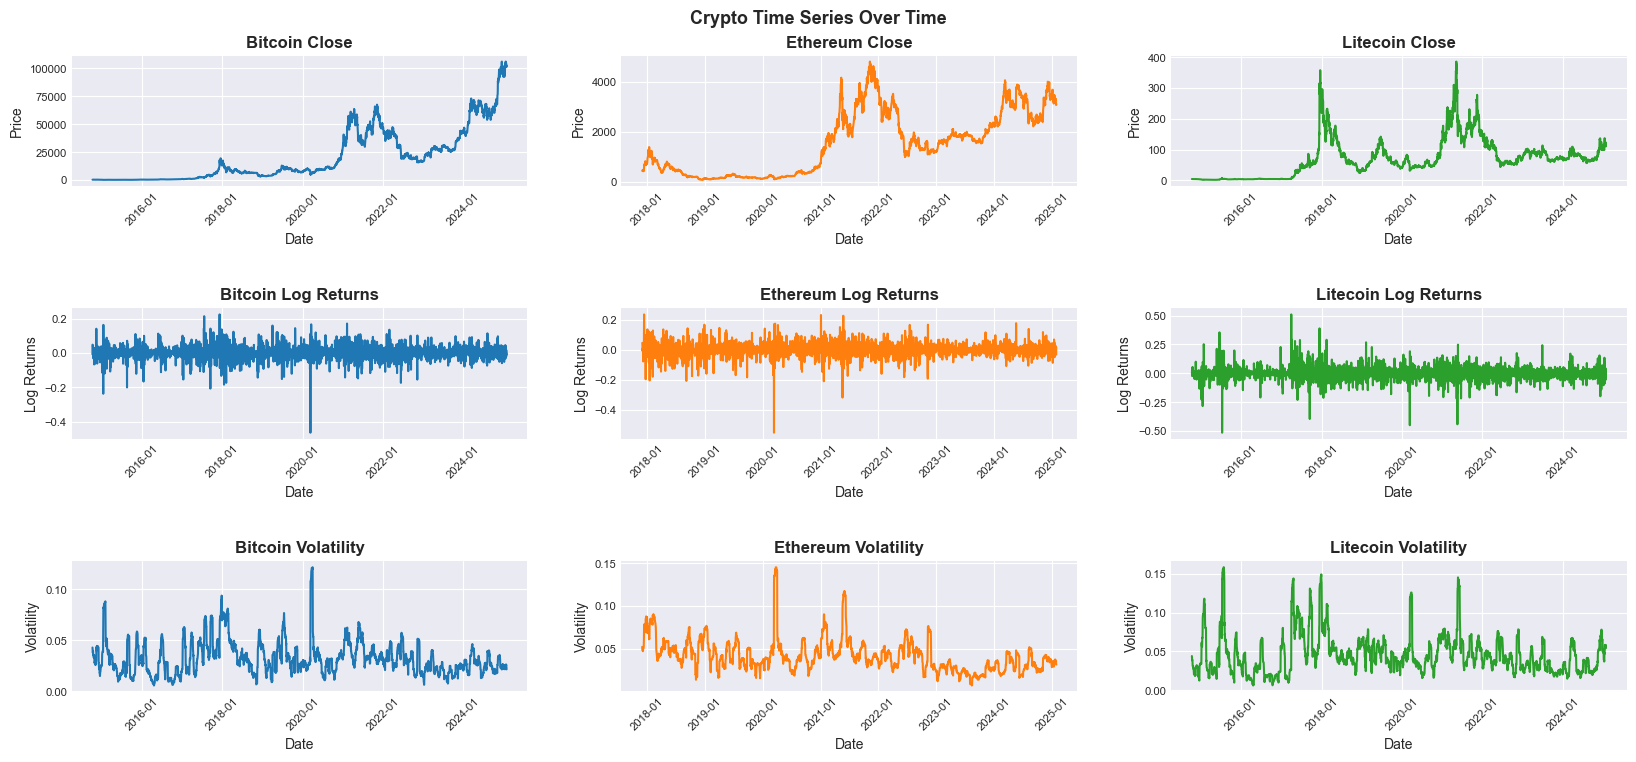

In [5]:
cryptos = [
    ("Bitcoin", bitcoin_data),
    ("Ethereum", ethereum_data),
    ("Litecoin", litecoin_data),
]

metrics = [
    ("Close", "Price"),
    ("Log Returns", "Log Returns"),
    ("Volatility", "Volatility"),
]

colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]
fig, ax = plt.subplots(len(metrics), len(cryptos), figsize=(17, 8), dpi=100)

for col, (crypto_name, crypto_data) in enumerate(cryptos):
    for row, (metric, ylabel) in enumerate(metrics):
        ax[row, col].plot(
            crypto_data["Date"],
            crypto_data[metric],
            label=crypto_name,
            color=colors[col],
            linewidth=1.5
        )
        ax[row, col].set_title(f"{crypto_name} {metric}", fontsize=12, fontweight="bold")
        ax[row, col].set_xlabel("Date", fontsize=10)
        ax[row, col].set_ylabel(ylabel, fontsize=10)
        
        ax[row, col].xaxis.set_major_formatter(DateFormatter("%Y-%m"))
        ax[row, col].tick_params(axis="x", rotation=45, labelsize=8)
        ax[row, col].tick_params(axis="y", labelsize=8)

plt.tight_layout(pad=3.0)
fig.suptitle("Crypto Time Series Over Time", fontsize=13, fontweight="bold")
plt.show()

### **🛠️ Creating Predictive Features**

To enhance the predictive power of our models, we will generate additional features from the existing time series data using the **`FeaturesCreator` object**. These features capture different aspects of market behavior and provide valuable input for machine learning models.

---

### **Features to be Created**
1. **Smoothed Volatility**:
   - **Weekly Volatility**: Rolling average of volatility over a 7-day window.
   - **Monthly Volatility**: Rolling average of volatility over a 30-day window.

2. **GARCH Volatility**:
   - Conditional volatility estimated using a **GARCH(1,1)** model, which captures clustering and persistence in volatility.

3. **Log Trading Range**:
   - The logarithmic difference between the high and low prices, capturing the daily price range on a log scale.

4. **Log Volume Change**:
   - The change in trading volume on a log scale.

This enriched dataset will improve the performance and robustness of our predictive models.  

We will provide example graphs for one cryptocurrency to illustrate the presented time series.

In [6]:
features_creator_bitcoin = FeaturesCreator(data=bitcoin_data)
features_creator_ethereum = FeaturesCreator(data=ethereum_data)
features_creator_litecoin = FeaturesCreator(data=litecoin_data)

features_creator_bitcoin.create_all_features()
features_creator_ethereum.create_all_features()
features_creator_litecoin.create_all_features()

bitcoin_data = features_creator_bitcoin.transformed_data
ethereum_data = features_creator_ethereum.transformed_data
litecoin_data = features_creator_litecoin.transformed_data

features = features_creator_bitcoin.features_names

# Exemple de données
bitcoin_data.head()

,Date,Open,High,Low,Close,Adj,Volume,Log Returns,Volatility,Weekly Volatility,Monthly Volatility,GARCH Volatility,Log Trading Range,Log Volume Change
3766,2014-10-08,336.12,354.36,327.19,352.94,352.94,54736300,0.048622,0.042931,0.042931,0.042931,0.032958,0.079772,NaN
3765,2014-10-09,352.75,382.73,347.69,365.03,365.03,83641104,0.033681,0.041557,0.042244,0.042244,0.032917,0.096019,0.424008
3764,2014-10-10,364.69,375.07,352.96,361.56,361.56,43665700,-0.009552,0.038797,0.041095,0.041095,0.031511,0.060758,-0.649972
3763,2014-10-11,361.36,367.19,355.95,362.30,362.30,13345200,0.002045,0.037781,0.040267,0.040267,0.030003,0.031089,-1.185406
3762,2014-10-12,362.61,379.43,356.14,378.55,378.55,17552800,0.043876,0.038999,0.040013,0.040013,0.031546,0.063346,0.274057


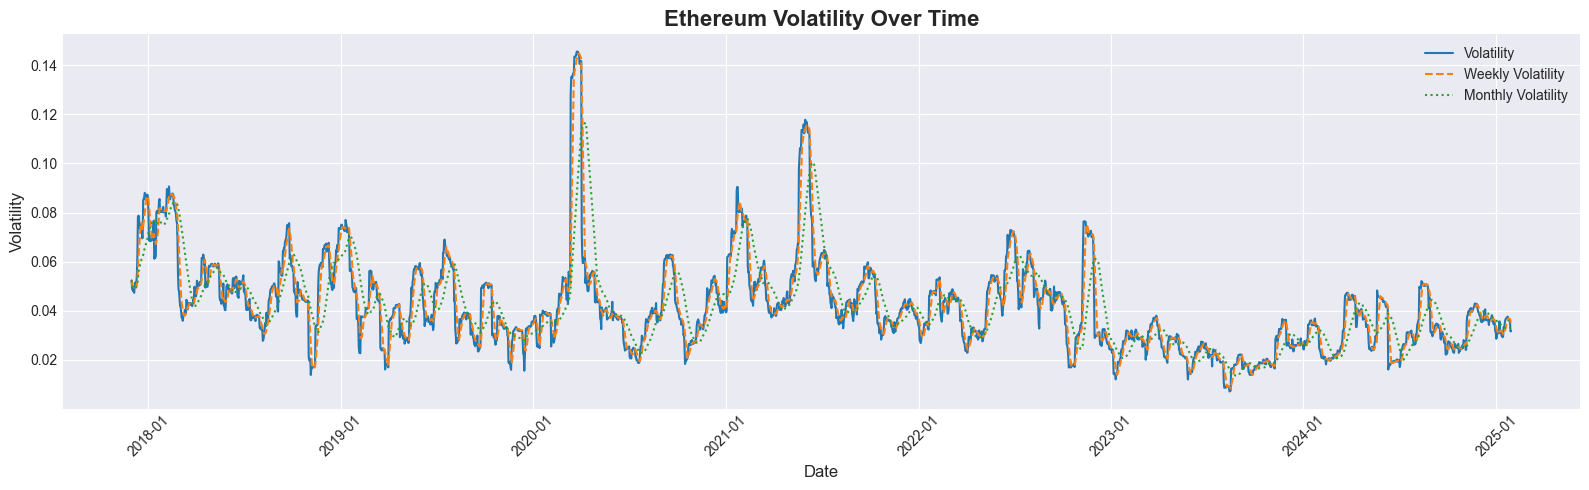

In [7]:
colors = ["#1f77b4", "#ff7f0e", "#2ca02c"]

plt.figure(figsize=(16, 5), dpi=100)
plt.plot(
    ethereum_data["Date"],
    ethereum_data["Volatility"],
    label="Volatility",
    color=colors[0],
    linewidth=1.5
)
plt.plot(
    ethereum_data["Date"],
    ethereum_data["Weekly Volatility"],
    label="Weekly Volatility",
    color=colors[1],
    linestyle="--",
    linewidth=1.5
)
plt.plot(
    ethereum_data["Date"],
    ethereum_data["Monthly Volatility"],
    label="Monthly Volatility",
    color=colors[2],
    linestyle=":",
    linewidth=1.5
)

plt.title("Ethereum Volatility Over Time", fontsize=16, fontweight="bold")
plt.xlabel("Date", fontsize=12)
plt.ylabel("Volatility", fontsize=12)
plt.legend(fontsize=10)

plt.gca().xaxis.set_major_formatter(DateFormatter("%Y-%m"))
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


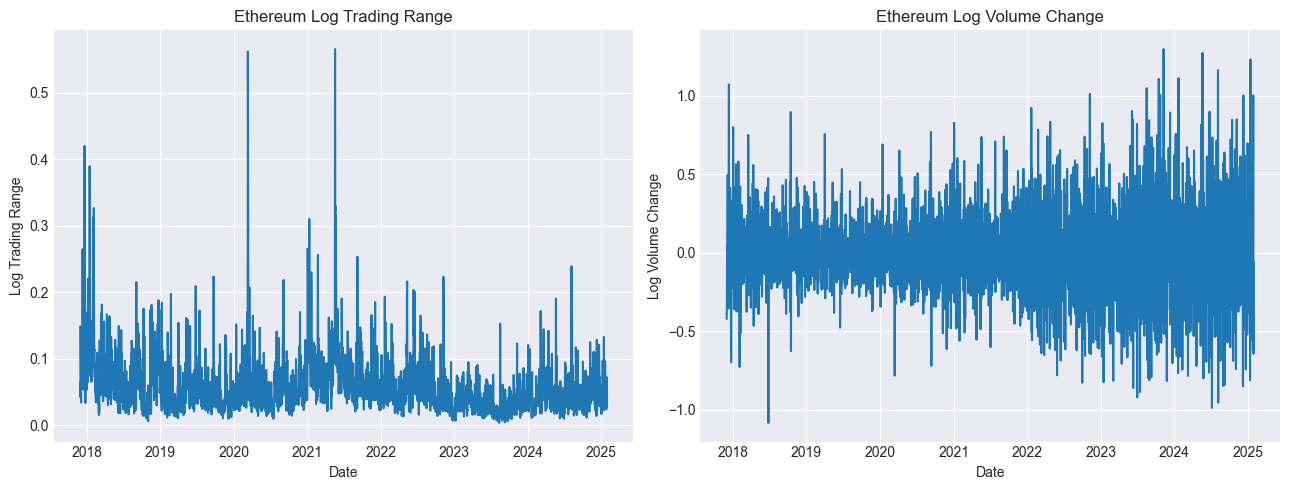

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(13, 5))
ax[0].plot(ethereum_data["Date"], ethereum_data["Log Trading Range"])
ax[0].set_title("Ethereum Log Trading Range")
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Log Trading Range")
ax[1].plot(ethereum_data["Date"], ethereum_data["Log Volume Change"])
ax[1].set_title("Ethereum Log Volume Change")
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Log Volume Change")
plt.tight_layout()
plt.show()

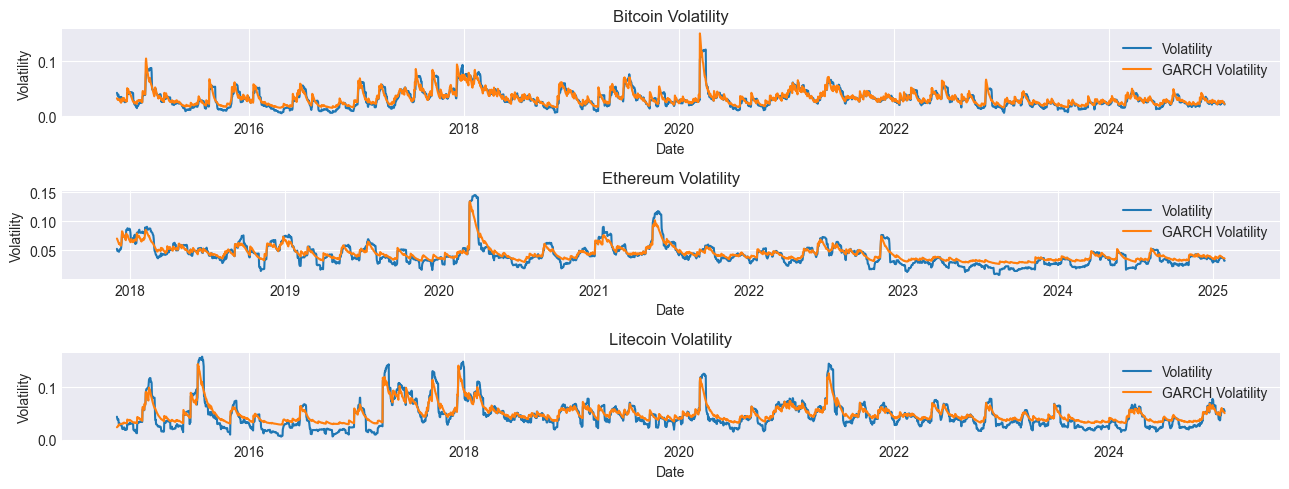

In [9]:
# plot garch volatility, realized volatility on the same plot for the 3 cryptocurrencies subplots
fig, ax = plt.subplots(3, 1, figsize=(13, 5))

ax[0].plot(bitcoin_data["Date"], bitcoin_data["Volatility"], label="Volatility")
ax[0].plot(bitcoin_data["Date"], bitcoin_data["GARCH Volatility"], label="GARCH Volatility")
ax[0].set_title("Bitcoin Volatility")
ax[0].set_xlabel("Date")
ax[0].set_ylabel("Volatility")
ax[0].legend()

ax[1].plot(ethereum_data["Date"], ethereum_data["Volatility"], label="Volatility")
ax[1].plot(ethereum_data["Date"], ethereum_data["GARCH Volatility"], label="GARCH Volatility")
ax[1].set_title("Ethereum Volatility")
ax[1].set_xlabel("Date")
ax[1].set_ylabel("Volatility")
ax[1].legend()

ax[2].plot(litecoin_data["Date"], litecoin_data["Volatility"], label="Volatility")
ax[2].plot(litecoin_data["Date"], litecoin_data["GARCH Volatility"], label="GARCH Volatility")
ax[2].set_title("Litecoin Volatility")
ax[2].set_xlabel("Date")
ax[2].set_ylabel("Volatility")
ax[2].legend()

plt.tight_layout()
plt.show()

Wee see that GARCH Predictions are pretty poor in terms of accuracy while capturing major cluster of volatility, which could be useful for our main model.

### **📊 Train-Test Split**

To evaluate prediction accuracy and portfolio optimization performance, we will split our data at the **beginning of 2024**. This setup will:
- Reserve the entire year of **2024** as the **test set**, serving as a reference period for assessing model performance.
- Use the remaining historical data as the **training set** for model development and feature engineering.

---

### **Data Availability**
- **Bitcoin (BTC)**: Approximately **10 years** of historical data for training.
- **Litecoin (LTC)**: Approximately **10 years** of historical data for training.
- **Ethereum (ETH)**: Only **6 years** of historical data are available for training on **Yahoo Finance**

---

This split ensures that the models are tested on unseen data while leveraging the longest available histories for each cryptocurrency during training. It also provides a realistic evaluation for 2024, reflecting actual market conditions. 🚀


In [10]:
bitcoin_data.dropna(inplace=True)
ethereum_data.dropna(inplace=True)
litecoin_data.dropna(inplace=True)

In [11]:
bitcoin_train_data = bitcoin_data[bitcoin_data['Date'] < test_start_date]
bitcoin_test_data = bitcoin_data[bitcoin_data['Date'] >= test_start_date]

ethereum_train_data = ethereum_data[ethereum_data['Date'] < test_start_date]
ethereum_test_data = ethereum_data[ethereum_data['Date'] >= test_start_date]

litecoin_train_data = litecoin_data[litecoin_data['Date'] < test_start_date]
litecoin_test_data = litecoin_data[litecoin_data['Date'] >= test_start_date]

# check proportion of test data
print(f"Bitcoin test data proportion: {round(len(bitcoin_test_data) / len(bitcoin_data)*100, 2)}%")
print(f"Ethereum test data proportion: {round(len(ethereum_test_data) / len(ethereum_data)*100, 2)}%")
print(f"Litecoin test data proportion: {round(len(litecoin_test_data) / len(litecoin_data)*100, 2)}%")

Bitcoin test data proportion: 10.49%
Ethereum test data proportion: 15.09%
Litecoin test data proportion: 10.49%


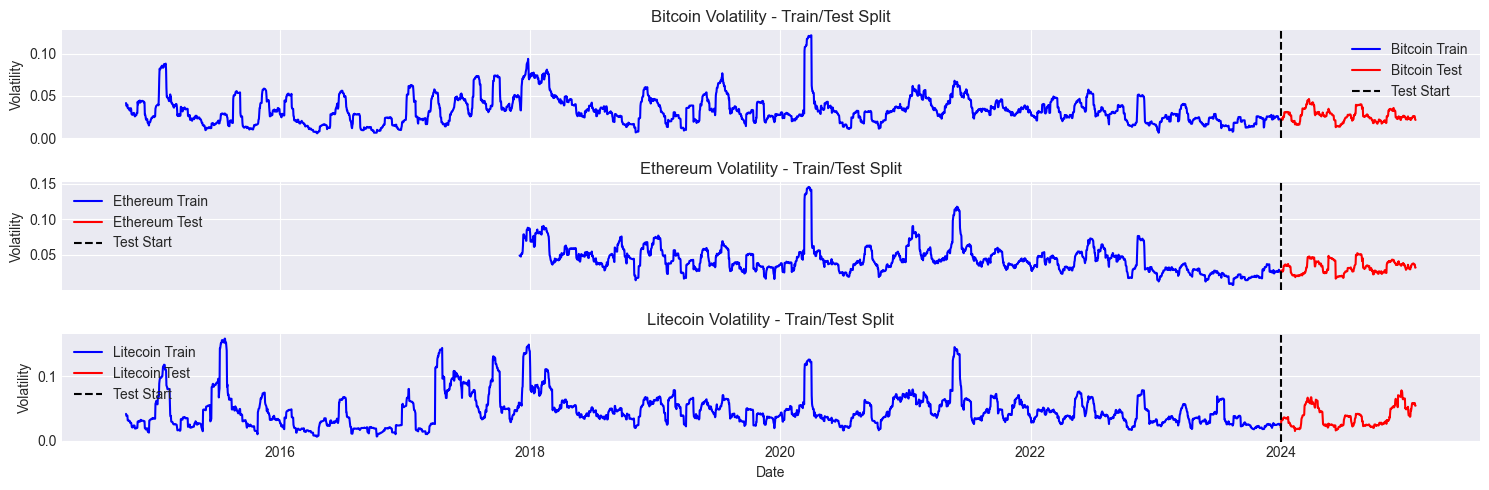

In [12]:
fig, axs = plt.subplots(3, 1, figsize=(15, 5), sharex=True)
axs[0].plot(bitcoin_train_data["Date"], bitcoin_train_data["Volatility"], label="Bitcoin Train", color="blue")
axs[0].plot(bitcoin_test_data["Date"], bitcoin_test_data["Volatility"], label="Bitcoin Test", color="red")
axs[0].axvline(test_start_date, color="black", linestyle="--", label="Test Start")
axs[0].set_title("Bitcoin Volatility - Train/Test Split")
axs[0].set_ylabel("Volatility")
axs[0].legend()

axs[1].plot(ethereum_train_data["Date"], ethereum_train_data["Volatility"], label="Ethereum Train", color="blue")
axs[1].plot(ethereum_test_data["Date"], ethereum_test_data["Volatility"], label="Ethereum Test", color="red")
axs[1].axvline(test_start_date, color="black", linestyle="--", label="Test Start")
axs[1].set_title("Ethereum Volatility - Train/Test Split")
axs[1].set_ylabel("Volatility")
axs[1].legend()

axs[2].plot(litecoin_train_data["Date"], litecoin_train_data["Volatility"], label="Litecoin Train", color="blue")
axs[2].plot(litecoin_test_data["Date"], litecoin_test_data["Volatility"], label="Litecoin Test", color="red")
axs[2].axvline(test_start_date, color="black", linestyle="--", label="Test Start")
axs[2].set_title("Litecoin Volatility - Train/Test Split")
axs[2].set_xlabel("Date")
axs[2].set_ylabel("Volatility")
axs[2].legend()

plt.tight_layout()
plt.show()

###  **🤖 Predicting Volatility with Advanced Models** 

We will predict cryptocurrency volatility using four advanced deep learning models: **GRU**, **LSTM**, **LSTM-GRU**, and **TCNN**. These models are implemented as objects that inherit from the **`ModelPipelineBase`** class, which provides a unified structure for data preprocessing, model training, and evaluation.

---

#### **The Models**
1. **LSTM (Long Short-Term Memory)**:
   - A powerful recurrent architecture for learning long-term dependencies in time series data.

2. **GRU (Gated Recurrent Unit)**:
   - A recurrent neural network designed for capturing sequential dependencies while mitigating vanishing gradient issues.

3. **LSTM-GRU Hybrid**:
   - A combination of LSTM and GRU layers to leverage the strengths of both architectures.

4. **TCNN (Temporal Convolutional Neural Network)**:
   - A model that uses convolutional layers to capture temporal patterns, offering a non-recurrent alternative for sequence modeling.

---

#### **How It Works**
**1. Data Preprocessing**
   - The models rely on **lagged features** created using the `create_lagged_features` method, which transforms the time series into supervised learning format:
     - For a lookback window of size \( T \), the model uses the past \( T \) time steps as input to predict the volatility over the next forecast horizon.
   - If normalization is enabled, the input data is scaled using **MinMaxScaler** to improve model convergence.

**2. Model Creation**
   - Each object implements a **`create_model`** method to define its specific architecture. For instance:
     - **GRU Pipeline**: Creates a two-layer GRU model with specified units, dropout rates, and output layers for forecasting.
     - Similar methods exist for LSTM, LSTM-GRU, and TCNN, where the layers are customized for their respective architectures.
   - The models are compiled with the **Adam optimizer** and **mean squared error (MSE)** as the loss function.

**3. Training**
   - Training is conducted using the `fit` method, which:
     - Splits the data into training and validation sets.
     - Trains the model for a defined number of epochs and batch size, logging the training history for evaluation.

---

These models will enable us to predict volatility accurately, forming the basis for optimizing portfolio strategies and market analysis.


In [13]:
features = features_creator_bitcoin.features_names
features = ['Volatility',
 'Weekly Volatility',
 'Monthly Volatility',
 'Log Trading Range',
 'Log Volume Change']

## Choix paramètres à rédiger !!!!!!!!!!!!!!!!!!!!!!!!!!

#### **Performance Assessment**
 The evaluation for all the models will be based on key metrics such as:

- Mean Squared Error (MSE)
- Root Mean Squared Error (RMSE)
- Mean Absolute Error (MAE)
- Mean Absolute Percentage Error (MAPE)

The goal of this process is to determine the best-performing model at t+5 (as it is our reference forecast horizon for the following portfolio optimization).

In [14]:
lookback = 30

# insert data from train for lookback window in the test data
bitcoin_test_data = bitcoin_test_data.reset_index(drop=True)
bitcoin_test_data = pd.concat([bitcoin_train_data.iloc[-lookback + 1:], bitcoin_test_data], ignore_index=True)

ethereum_test_data = ethereum_test_data.reset_index(drop=True)
ethereum_test_data = pd.concat([ethereum_train_data.iloc[-lookback + 1:], ethereum_test_data], ignore_index=True)

litecoin_test_data = litecoin_test_data.reset_index(drop=True)
litecoin_test_data = pd.concat([litecoin_train_data.iloc[-lookback + 1:], litecoin_test_data], ignore_index=True)

**1. LSTM**

In [15]:
bitcoin_pipeline = LSTMPipeline(forecast_horizon=5, epochs=10, batch_size=32, validation_split=0.1, normalize=True, lookback=30, dropout_rate=0.05)
bitcoin_model = bitcoin_pipeline.fit(bitcoin_train_data[features].values, bitcoin_train_data["Volatility"].values.astype(np.float64))

ethereum_pipeline = LSTMPipeline(forecast_horizon=5, epochs=15, batch_size=32, validation_split=0.1, dropout_rate=0, normalize=True, lookback=30)
ethereum_model= ethereum_pipeline.fit(ethereum_train_data[features].values, ethereum_train_data["Volatility"].values.astype(np.float64))

litecoin_pipeline = LSTMPipeline(forecast_horizon=5, epochs=10, batch_size=32, validation_split=0.1, normalize=True, lookback=30, dropout_rate=0)
litecoin_model= litecoin_pipeline.fit(litecoin_train_data[features].values, litecoin_train_data["Volatility"].values.astype(np.float64))

print("Bitcoin Train")
bitcoin_pipeline.evaluate_metrics(bitcoin_train_data[features].values, bitcoin_train_data["Volatility"].values.astype(np.float64), only_last=True)
print("Bitcoin Test")
bitcoin_pipeline.evaluate_metrics(bitcoin_test_data[features].values, bitcoin_test_data["Volatility"].values.astype(np.float64), only_last=True)

print("Ethereum Train")
ethereum_pipeline.evaluate_metrics(ethereum_train_data[features].values, ethereum_train_data["Volatility"].values.astype(np.float64), only_last=True)
print("Ethereum Test")
ethereum_pipeline.evaluate_metrics(ethereum_test_data[features].values, ethereum_test_data["Volatility"].values.astype(np.float64), only_last=True)

print("Litecoin Train")
litecoin_pipeline.evaluate_metrics(litecoin_train_data[features].values, litecoin_train_data["Volatility"].values.astype(np.float64), only_last=True)
print("Litecoin Test")
litecoin_pipeline.evaluate_metrics(litecoin_test_data[features].values, litecoin_test_data["Volatility"].values.astype(np.float64), only_last=True)

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - loss: 0.0231 - val_loss: 0.0013
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0051 - val_loss: 9.1050e-04
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0041 - val_loss: 8.5280e-04
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.0037 - val_loss: 8.7074e-04
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0035 - val_loss: 8.1446e-04
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0036 - val_loss: 7.6865e-04
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 24ms/step - loss: 0.0033 - val_loss: 7.6337e-04
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0033 - val_loss: 8.8053e-04
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.0032 - val_loss: 9.5366e-04
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 36ms/step - loss: 0.0033 - val_loss: 7.3699e-04
Epoch 1/15
62/62 ━━━━━━━━━━━━━━━━━━━━ 12s 64ms/step - loss: 0.0228 - val_loss: 0.0020
Epoch 2/15
62/62 ━━━━━━━━━━

**2.GRU**

In [16]:
bitcoin_pipeline = GRUPipeline(forecast_horizon=5, epochs=10, batch_size=32, validation_split=0.1, normalize=True, lookback=30)
bitcoin_model = bitcoin_pipeline.fit(bitcoin_train_data[features].values, bitcoin_train_data["Volatility"].values.astype(np.float64))

ethereum_pipeline = GRUPipeline(forecast_horizon=5, epochs=10, batch_size=32, validation_split=0.1, dropout_rate=0, normalize=True, lookback=30)
ethereum_model= ethereum_pipeline.fit(ethereum_train_data[features].values, ethereum_train_data["Volatility"].values.astype(np.float64))

litecoin_pipeline = GRUPipeline(forecast_horizon=5, epochs=10, batch_size=32, validation_split=0.1, normalize=True, lookback=30)
litecoin_model= litecoin_pipeline.fit(litecoin_train_data[features].values, litecoin_train_data["Volatility"].values.astype(np.float64))

print("Bitcoin Train")
bitcoin_pipeline.evaluate_metrics(bitcoin_train_data[features].values, bitcoin_train_data["Volatility"].values.astype(np.float64), only_last=True)
print("Bitcoin Test")
bitcoin_pipeline.evaluate_metrics(bitcoin_test_data[features].values, bitcoin_test_data["Volatility"].values.astype(np.float64), only_last=True)

print("Ethereum Train")
ethereum_pipeline.evaluate_metrics(ethereum_train_data[features].values, ethereum_train_data["Volatility"].values.astype(np.float64), only_last=True)
print("Ethereum Test")
ethereum_pipeline.evaluate_metrics(ethereum_test_data[features].values, ethereum_test_data["Volatility"].values.astype(np.float64), only_last=True)

print("Litecoin Train")
litecoin_pipeline.evaluate_metrics(litecoin_train_data[features].values, litecoin_train_data["Volatility"].values.astype(np.float64), only_last=True)
print("Litecoin Test")
litecoin_pipeline.evaluate_metrics(litecoin_test_data[features].values, litecoin_test_data["Volatility"].values.astype(np.float64), only_last=True)

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 51s 183ms/step - loss: 0.0237 - val_loss: 0.0012
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - loss: 0.0048 - val_loss: 8.6235e-04
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - loss: 0.0040 - val_loss: 8.5712e-04
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - loss: 0.0036 - val_loss: 7.8298e-04
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - loss: 0.0039 - val_loss: 0.0010
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - loss: 0.0037 - val_loss: 8.2046e-04
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 45ms/step - loss: 0.0037 - val_loss: 7.4592e-04
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.0035 - val_loss: 7.4322e-04
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0037 - val_loss: 8.3615e-04
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0036 - val_loss: 7.9171e-04
Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 15s 67ms/step - loss: 0.0219 - val_loss: 0.0014
Epoch 2/10
62/62 ━━━

**3.LSTM-GRU Model**

In [17]:
bitcoin_pipeline = LSTMGRUPipeline(forecast_horizon=5, epochs=10, batch_size=32, validation_split=0.1, normalize=True, lookback=30)
bitcoin_model = bitcoin_pipeline.fit(bitcoin_train_data[features].values, bitcoin_train_data["Volatility"].values.astype(np.float64))

ethereum_pipeline = LSTMGRUPipeline(forecast_horizon=5, epochs=10, batch_size=32, validation_split=0.1, dropout_rate=0, normalize=True, lookback=30)
ethereum_model= ethereum_pipeline.fit(ethereum_train_data[features].values, ethereum_train_data["Volatility"].values.astype(np.float64))

litecoin_pipeline = LSTMGRUPipeline(forecast_horizon=5, epochs=10, batch_size=32, validation_split=0.1, normalize=True, lookback=30)
litecoin_model= litecoin_pipeline.fit(litecoin_train_data[features].values, litecoin_train_data["Volatility"].values.astype(np.float64))

print("Bitcoin Train")
bitcoin_pipeline.evaluate_metrics(bitcoin_train_data[features].values, bitcoin_train_data["Volatility"].values.astype(np.float64), only_last=True)
print("Bitcoin Test")
bitcoin_pipeline.evaluate_metrics(bitcoin_test_data[features].values, bitcoin_test_data["Volatility"].values.astype(np.float64), only_last=True)

print("Ethereum Train")
ethereum_pipeline.evaluate_metrics(ethereum_train_data[features].values, ethereum_train_data["Volatility"].values.astype(np.float64), only_last=True)
print("Ethereum Test")
ethereum_pipeline.evaluate_metrics(ethereum_test_data[features].values, ethereum_test_data["Volatility"].values.astype(np.float64), only_last=True)

print("Litecoin Train")
litecoin_pipeline.evaluate_metrics(litecoin_train_data[features].values, litecoin_train_data["Volatility"].values.astype(np.float64), only_last=True)
print("Litecoin Test")
litecoin_pipeline.evaluate_metrics(litecoin_test_data[features].values, litecoin_test_data["Volatility"].values.astype(np.float64), only_last=True)

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 0.0279 - val_loss: 0.0013
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0049 - val_loss: 0.0010
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0043 - val_loss: 9.4622e-04
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0040 - val_loss: 9.6834e-04
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0044 - val_loss: 0.0012
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0041 - val_loss: 9.5826e-04
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0034 - val_loss: 8.8934e-04
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0037 - val_loss: 9.4036e-04
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0037 - val_loss: 8.6548e-04
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0035 - val_loss: 0.0010
Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 9s 45ms/step - loss: 0.0208 - val_loss: 0.0016
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 2

**4. TCNN Model**

In [18]:
bitcoin_pipeline = TCNNPipeline(forecast_horizon=5, epochs=10, batch_size=32, validation_split=0.1, normalize=True, lookback=30)
bitcoin_model = bitcoin_pipeline.fit(bitcoin_train_data[features].values, bitcoin_train_data["Volatility"].values.astype(np.float64))

ethereum_pipeline = TCNNPipeline(forecast_horizon=5, epochs=10, batch_size=32, validation_split=0.1, dropout_rate=0, normalize=True, lookback=30)
ethereum_model= ethereum_pipeline.fit(ethereum_train_data[features].values, ethereum_train_data["Volatility"].values.astype(np.float64))

litecoin_pipeline = TCNNPipeline(forecast_horizon=5, epochs=10, batch_size=32, validation_split=0.1, normalize=True, lookback=30)
litecoin_model= litecoin_pipeline.fit(litecoin_train_data[features].values, litecoin_train_data["Volatility"].values.astype(np.float64))

print("Bitcoin Train")
bitcoin_pipeline.evaluate_metrics(bitcoin_train_data[features].values, bitcoin_train_data["Volatility"].values.astype(np.float64), only_last=True)
print("Bitcoin Test")
bitcoin_pipeline.evaluate_metrics(bitcoin_test_data[features].values, bitcoin_test_data["Volatility"].values.astype(np.float64), only_last=True)

print("Ethereum Train")
ethereum_pipeline.evaluate_metrics(ethereum_train_data[features].values, ethereum_train_data["Volatility"].values.astype(np.float64), only_last=True)
print("Ethereum Test")
ethereum_pipeline.evaluate_metrics(ethereum_test_data[features].values, ethereum_test_data["Volatility"].values.astype(np.float64), only_last=True)

print("Litecoin Train")
litecoin_pipeline.evaluate_metrics(litecoin_train_data[features].values, litecoin_train_data["Volatility"].values.astype(np.float64), only_last=True)
print("Litecoin Test")
litecoin_pipeline.evaluate_metrics(litecoin_test_data[features].values, litecoin_test_data["Volatility"].values.astype(np.float64), only_last=True)

Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0770 - val_loss: 8.9182e-04
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0038 - val_loss: 9.1634e-04
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0034 - val_loss: 8.9919e-04
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0030 - val_loss: 7.7140e-04
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0029 - val_loss: 7.7896e-04
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0029 - val_loss: 6.9463e-04
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0030 - val_loss: 6.8859e-04
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0029 - val_loss: 8.7676e-04
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0029 - val_loss: 9.5633e-04
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0032 - val_loss: 9.5488e-04
Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - loss: 0.0395 - val_loss: 0.0016
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━

### Final model

In [19]:
bitcoin_pipeline = LSTMPipeline(forecast_horizon=5, epochs=10, batch_size=32, validation_split=0.1, normalize=True, lookback=30, dropout_rate=0.05)
bitcoin_model = bitcoin_pipeline.fit(bitcoin_train_data[features].values, bitcoin_train_data["Volatility"].values.astype(np.float64))

ethereum_pipeline = LSTMPipeline(forecast_horizon=5, epochs=10, batch_size=32, validation_split=0.1, dropout_rate=0, normalize=True, lookback=30)
ethereum_model= ethereum_pipeline.fit(ethereum_train_data[features].values, ethereum_train_data["Volatility"].values.astype(np.float64))

litecoin_pipeline = LSTMPipeline(forecast_horizon=5, epochs=10, batch_size=32, validation_split=0.1, normalize=True, lookback=30, dropout_rate=0)
litecoin_model= litecoin_pipeline.fit(litecoin_train_data[features].values, litecoin_train_data["Volatility"].values.astype(np.float64))


Epoch 1/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 9s 34ms/step - loss: 0.0231 - val_loss: 0.0013
Epoch 2/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.0051 - val_loss: 9.1050e-04
Epoch 3/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0041 - val_loss: 8.5280e-04
Epoch 4/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0037 - val_loss: 8.7074e-04
Epoch 5/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0035 - val_loss: 8.1446e-04
Epoch 6/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0036 - val_loss: 7.6865e-04
Epoch 7/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0033 - val_loss: 7.6337e-04
Epoch 8/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0033 - val_loss: 8.8053e-04
Epoch 9/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0032 - val_loss: 9.5366e-04
Epoch 10/10
94/94 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0033 - val_loss: 7.3699e-04
Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step - loss: 0.0228 - val_loss: 0.0020
Epoch 2/10
62/62 ━━━━━━━━━━━

In [20]:
# Complete evaluation
print("----------------Bitcoin----------------")
print("")
print("Train")
bitcoin_pipeline.evaluate_metrics(bitcoin_train_data[features].values, bitcoin_train_data["Volatility"].values.astype(np.float64))
print("")
print("Test")
bitcoin_pipeline.evaluate_metrics(bitcoin_test_data[features].values, bitcoin_test_data["Volatility"].values.astype(np.float64))

print("----------------Ethereum----------------")
print("Train")
print("")
ethereum_pipeline.evaluate_metrics(ethereum_train_data[features].values, ethereum_train_data["Volatility"].values.astype(np.float64))
print("Test")
ethereum_pipeline.evaluate_metrics(ethereum_test_data[features].values, ethereum_test_data["Volatility"].values.astype(np.float64))

print("----------------Litecoin----------------")
print("Train")
litecoin_pipeline.evaluate_metrics(litecoin_train_data[features].values, litecoin_train_data["Volatility"].values.astype(np.float64))
print("Test")
litecoin_pipeline.evaluate_metrics(litecoin_test_data[features].values, litecoin_test_data["Volatility"].values.astype(np.float64))

----------------Bitcoin----------------

Train

Evaluation Metrics by Time Step:
Time Step MSE            RMSE           MAE            MAPE (%)       
------------------------------------------------------------
1         0.0000         0.0041         0.0029         10.9173        
2         0.0000         0.0051         0.0034         12.6612        
3         0.0000         0.0061         0.0040         13.9974        
4         0.0000         0.0068         0.0044         15.5262        
5         0.0001         0.0076         0.0049         16.3705        

Overall Evaluation Metrics:
------------------------------------------------------------
Metric              Value          
Overall MSE         0.0000         
Overall RMSE        0.0061         
Overall MAE         0.0039         
Overall MAPE (%)    13.8945        

Test

Evaluation Metrics by Time Step:
Time Step MSE            RMSE           MAE            MAPE (%)       
---------------------------------------------------

105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
105/105 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


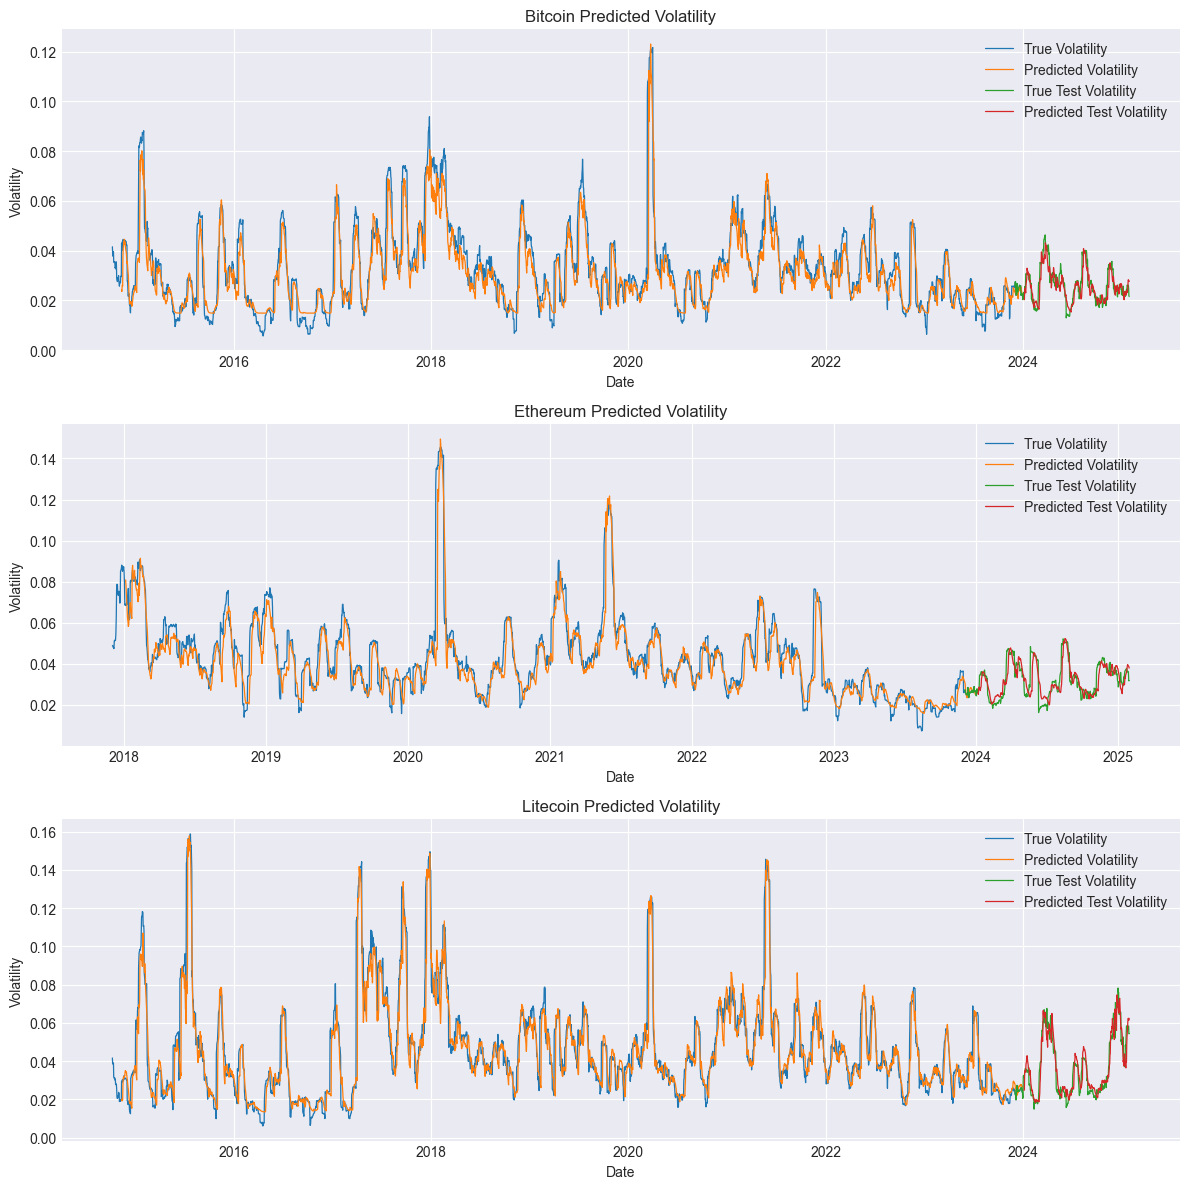

In [21]:
def predict_and_plot(pipeline, train_data, test_data, ax, title):
    # keep only t+5 predictions
    y_pred_train = pipeline.predict(train_data[features].values)[:, 4]
    y_pred_test = pipeline.predict(test_data[features].values)[:, 4]
    
    ax.plot(train_data["Date"], train_data["Volatility"], label="True Volatility", linewidth=0.9)
    ax.plot(train_data["Date"][-len(y_pred_train):], y_pred_train, label="Predicted Volatility",  linewidth=0.9)
    ax.plot(test_data["Date"], test_data["Volatility"], label="True Test Volatility",  linewidth=0.9)
    ax.plot(test_data["Date"][-len(y_pred_test):], y_pred_test, label="Predicted Test Volatility",  linewidth=0.9)
    ax.set_title(title)
    ax.set_xlabel("Date")
    ax.set_ylabel("Volatility")
    ax.legend()
    return y_pred_train, y_pred_test

fig, ax = plt.subplots(3, 1, figsize=(12, 12))

y_pred_bitcoin_train, y_pred_bitcoin_test = predict_and_plot(bitcoin_pipeline, bitcoin_train_data, bitcoin_test_data, ax[0], "Bitcoin Predicted Volatility")
y_pred_ethereum_train, y_pred_ethereum_test = predict_and_plot(ethereum_pipeline, ethereum_train_data, ethereum_test_data, ax[1], "Ethereum Predicted Volatility")
y_pred_litecoin_train, y_pred_litecoin_test = predict_and_plot(litecoin_pipeline, litecoin_train_data, litecoin_test_data, ax[2], "Litecoin Predicted Volatility")

plt.tight_layout()
plt.show()

### **📊 Portfolio Optimization**

We will optimize portfolio allocations using the **`PortfolioConstructor`** object and compare the performance of several portfolio strategies. The focus will be on evaluating **cumulative returns** of different methods against a simple **equally weighted portfolio**.

---

##### **Portfolio Optimization Strategies**
1. **Risk Parity**:
   - Allocates weights based on the inverse of asset volatilities.
   - Ensures that each asset contributes equally to the portfolio's overall risk.

2. **Target Volatility Risk Parity**:
   - Extends the simple Risk Parity approach by scaling weights to achieve a specified target portfolio volatility.

3. **Equally Weighted Portfolio (Benchmark)**:
   - A simple benchmark strategy where all assets are assigned equal weights at each rebalancing period.


In [22]:
y_pred_all_currency = pd.DataFrame({"bitcoin": y_pred_bitcoin_test.flatten(), "ethereum": y_pred_ethereum_test.flatten(), "litecoin": y_pred_litecoin_test.flatten()})
portfolio_constructor = PortfolioConstructor(volatility_time_series=y_pred_all_currency)
y_pred_all_currency.columns = [col.capitalize() for col in y_pred_all_currency.columns]
display(y_pred_all_currency.head(2))

,Bitcoin,Ethereum,Litecoin
0,0.020360,0.025565,0.024733
1,0.020287,0.025034,0.024987


**1. Risk Parity**

In [23]:
weights = portfolio_constructor.risk_parity_weights_simple()

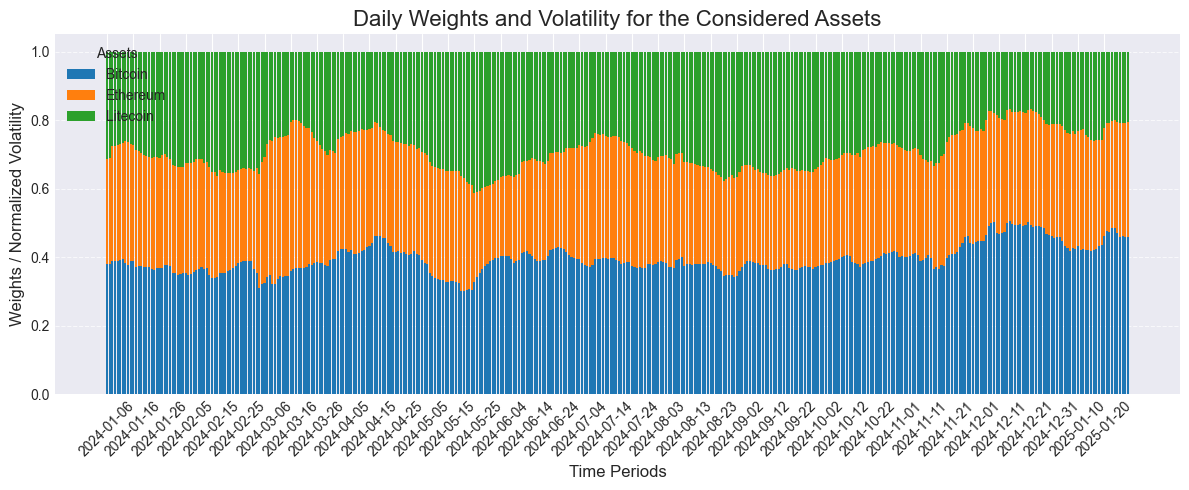

In [24]:
# Conversion en DataFrame pour faciliter le traçage
weights_df = pd.DataFrame(weights, columns=y_pred_all_currency.columns)

# Création du graphique
plt.figure(figsize=(12, 5))

# Tracer chaque colonne comme une barre empilée
bottom_values = np.zeros(len(weights))  # Initialisation des bases pour les barres empilées
for column in weights_df.columns:
    plt.bar(weights_df.index, weights_df[column], bottom=bottom_values, label=column)
    bottom_values += weights_df[column]


# Configuration du graphique
plt.title("Daily Weights and Volatility for the Considered Assets", fontsize=16)
plt.xlabel("Time Periods", fontsize=12)
plt.ylabel("Weights / Normalized Volatility", fontsize=12)
plt.legend(title="Assets", fontsize=10, loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.xticks(weights_df.index[::10], bitcoin_data["Date"][-len(weights_df):].dt.strftime('%Y-%m-%d').tolist()[::10], rotation=45)
# Afficher le graphique
plt.tight_layout()
plt.show()
# Add date labels to the x-axis

In [25]:
bitcoin_log_returns = bitcoin_test_data["Log Returns"][-len(weights_df):].values
eth_log_returns = ethereum_test_data["Log Returns"][-len(weights_df):].values
ltc_log_returns = litecoin_test_data["Log Returns"][-len(weights_df):].values

# Rendements du portefeuille
log_returns_matrix = np.array([bitcoin_log_returns, eth_log_returns, ltc_log_returns]).T
portfolio_returns = np.sum(weights * log_returns_matrix, axis=1)

# Rendements du portefeuille équilibré
balanced_weights = np.array([1/3, 1/3, 1/3])
balanced_returns = np.sum(balanced_weights * log_returns_matrix, axis=1)

# Rendements cumulés
cumulative_portfolio_return = np.prod(1 + portfolio_returns) - 1
cumulative_balanced_return = np.prod(1 + balanced_returns) - 1

# Affichage des résultats
print(f"Rendement cumulé (portefeuille dynamique): {cumulative_portfolio_return:.2%}")
print(f"Rendement cumulé (portefeuille équilibré): {cumulative_balanced_return:.2%}")

Rendement cumulé (portefeuille dynamique): 54.31%
Rendement cumulé (portefeuille équilibré): 48.94%


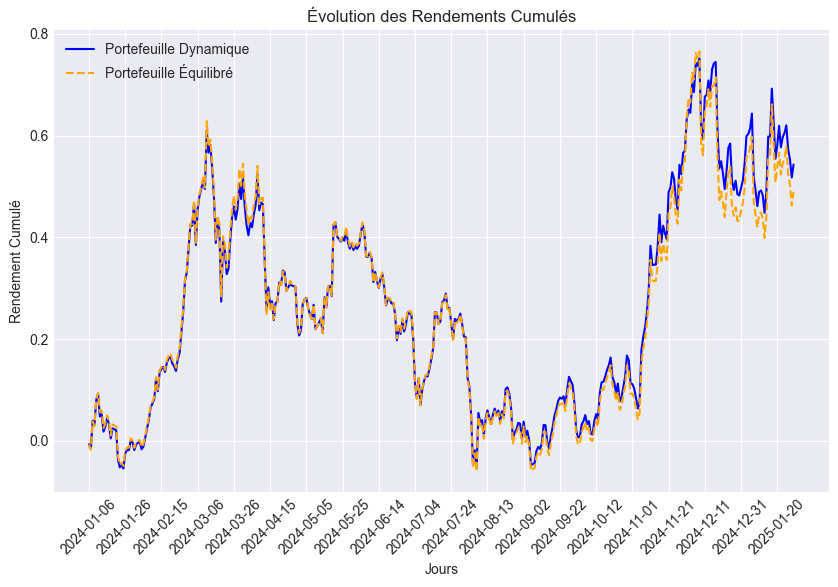

In [26]:
cumulative_portfolio_returns = np.cumprod(1 + portfolio_returns) - 1
cumulative_balanced_returns = np.cumprod(1 + balanced_returns) - 1

plt.figure(figsize=(10, 6))
plt.plot(cumulative_portfolio_returns, label="Portefeuille Dynamique", color='blue')
plt.plot(cumulative_balanced_returns, label="Portefeuille Équilibré", color='orange', linestyle='--')
plt.xticks(weights_df.index[::20], bitcoin_data["Date"][-len(weights_df):].dt.strftime('%Y-%m-%d').tolist()[::20], rotation=45)

plt.title("Évolution des Rendements Cumulés")
plt.xlabel("Jours")
plt.ylabel("Rendement Cumulé")
plt.legend()
plt.grid(True)
plt.show()

**2. VolTarget Portfolio**

In [27]:
portfolio_market_vol = PortfolioConstructor(volatility_time_series=y_pred_all_currency, target_vol_factor=1.0)
print(f" Volatilité cible basée sur le marché : {portfolio_market_vol.target_volatility:.4f}")

AttributeError: 'PortfolioConstructor' object has no attribute 'target_volatility'

In [62]:
y_pred_all_currency = pd.DataFrame({"bitcoin": y_pred_bitcoin_test.flatten(), "ethereum": y_pred_ethereum_test.flatten(), "litecoin": y_pred_litecoin_test.flatten()})

In [64]:
#y_pred_all_currency = pd.DataFrame({"bitcoin": y_pred_bitcoin_test.flatten(), "ethereum": y_pred_ethereum_test.flatten(), "litecoin": y_pred_litecoin_test.flatten()})
#portfolio_constructor = PortfolioConstructor(volatility_time_series=y_pred_all_currency)
portfolio_market_vol = PortfolioConstructor(volatility_time_series=y_pred_all_currency, target_vol_factor=1.0)

print(f" Volatilité cible basée sur le marché : {portfolio_market_vol.target_volatility:.4f}")

 Volatilité cible basée sur le marché : 0.0398


In [65]:

weights_target_market = portfolio_market_vol.risk_parity_weights_simple_target()
print(f"Nouvelle Forme de weights_target_market : {weights_target_market.shape}")
print(f"Poids Optimisés avec Volatilité Cible (Marché) :")
display(weights_target_market)


Nouvelle Forme de weights_target_market : (388, 3)
Poids Optimisés avec Volatilité Cible (Marché) :


,bitcoin,ethereum,litecoin
0,0.359162,0.328021,0.312817
1,0.365187,0.323303,0.311510
2,0.370286,0.364572,0.265142
3,0.363384,0.364883,0.271733
4,0.361588,0.364647,0.273766
...,...,...,...
383,0.451690,0.347645,0.200665
384,0.448512,0.356304,0.195184
385,0.444354,0.358092,0.197554
386,0.438866,0.359393,0.201741


In [66]:
## Convertir la Volatilité en Échelle Annuelle
annual_target_volatility = portfolio_market_vol.target_volatility * np.sqrt(252)
print(f"Volatilité Cible Annuelle : {annual_target_volatility:.2%}")


Volatilité Cible Annuelle : 63.18%


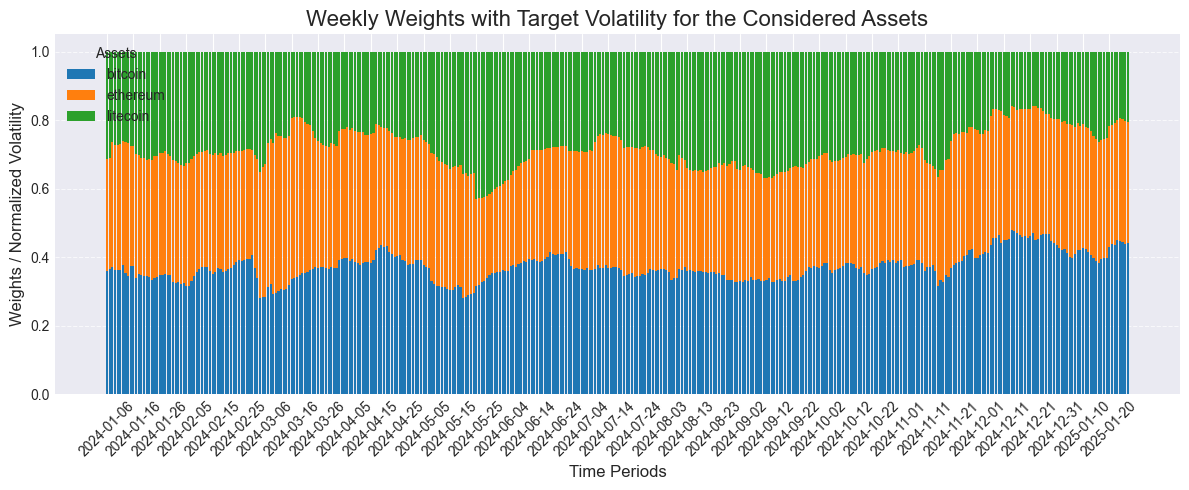

In [67]:
weights_target_market_df = pd.DataFrame(weights_target_market, columns=y_pred_all_currency.columns)

#  Création du graphique pour Risk Parity avec Target Volatility
plt.figure(figsize=(12, 5))

# Tracer chaque colonne comme une barre empilée
bottom_values = np.zeros(len(weights_target_market_df))  # Initialisation des bases pour les barres empilées
for column in weights_target_market_df.columns:
    plt.bar(weights_target_market_df.index, weights_target_market_df[column], bottom=bottom_values, label=column)
    bottom_values += weights_target_market_df[column]

#  Configuration du graphique
plt.title("Weekly Weights with Target Volatility for the Considered Assets", fontsize=16)
plt.xlabel("Time Periods", fontsize=12)
plt.ylabel("Weights / Normalized Volatility", fontsize=12)
plt.legend(title="Assets", fontsize=10, loc='upper left')
plt.grid(axis='y', linestyle='--', alpha=0.7)

#  Ajout des dates sur l'axe des X
plt.xticks(weights_target_market_df.index[::10], bitcoin_data["Date"][-len(weights_target_market_df):].dt.strftime('%Y-%m-%d').tolist()[::10], rotation=45)

#  Affichage du graphique
plt.tight_layout()
plt.show()

In [43]:
## essaie avec covariance un peu compliqué a voir apres je crois avoir une idée !

In [31]:
log_returns_test_df = pd.DataFrame({
    "Bitcoin": bitcoin_data["Log Returns"],
    "Ethereum": ethereum_data["Log Returns"],
    "Litecoin": litecoin_data["Log Returns"]
})

window_size = 21
cov_matrix_test = log_returns_test_df.rolling(window=window_size).cov(pairwise=True).dropna()


print("✅ Matrice de Covariance pour la dernière période :")
latest_date = cov_matrix_test.index.get_level_values(0).unique()[-1]  
latest_cov_matrix = cov_matrix_test.loc[latest_date]
display(latest_cov_matrix)


✅ Matrice de Covariance pour la dernière période :


,Bitcoin,Ethereum,Litecoin
Bitcoin,0.006734,-0.000780,-0.000339
Ethereum,-0.000780,0.004856,0.007504
Litecoin,-0.000339,0.007504,0.018606


In [32]:
# 📌 Conversion propre de la covariance
latest_cov_matrix_np = latest_cov_matrix.to_numpy()

# 📌 Appliquer Risk Parity avec la covariance bien formatée
weights_optimized = portfolio_constructor.risk_parity_weights(latest_cov_matrix_np)

# 📌 Vérifier la nouvelle forme du résultat
print(f"✅ Nouvelle Forme de weights_optimized : {weights_optimized.shape}")
print(f"✅ Poids Optimisés pour la période {latest_date}:")
display(weights_optimized)


✅ Nouvelle Forme de weights_optimized : (1, 3)
✅ Poids Optimisés pour la période 2614:


,Bitcoin,Ethereum,Litecoin
0,0.433922,0.384396,0.181682


## Weekly time step

In [ ]:
bitcoin_weekly = bitcoin_data.set_index("Date").resample("W").last()
ethereum_weekly = ethereum_data.set_index("Date").resample("W").last()
litecoin_weekly = litecoin_data.set_index("Date").resample("W").last()

print(bitcoin_weekly.shape)
bitcoin_weekly.head()

(539, 13)


,Open,High,Low,Close,Adj,Volume,Log Returns,Volatility,Weekly Volatility,Monthly Volatility,GARCH Volatility,Log Trading Range,Log Volume Change
Date,,,,,,,,,,,,,
2014-10-12,362.61,379.43,356.14,378.55,378.55,17552800,0.043876,0.038999,0.040013,0.040013,0.031550,0.063346,0.274057
2014-10-19,391.25,393.94,386.46,389.55,389.55,5914570,-0.004840,0.033069,0.035657,0.037472,0.027092,0.019170,-0.657667
2014-10-26,347.49,359.22,343.93,354.70,354.70,11272500,0.021170,0.028182,0.032198,0.035529,0.030204,0.043497,-0.475064
2014-11-02,326.08,329.05,320.63,325.89,325.89,8603620,0.000430,0.027825,0.028556,0.033652,0.031529,0.025922,-0.661859
2014-11-09,345.38,363.63,344.26,363.26,363.26,24205600,0.050155,0.029706,0.027246,0.031413,0.029994,0.054740,1.042354


In [41]:
# Train and test split
bitcoin_train_weekly = bitcoin_weekly[bitcoin_weekly.index < test_start_date]
bitcoin_test_weekly = bitcoin_weekly[bitcoin_weekly.index >= test_start_date]

ethereum_train_weekly = ethereum_weekly[ethereum_weekly.index < test_start_date]
ethereum_test_weekly = ethereum_weekly[ethereum_weekly.index >= test_start_date]

litecoin_train_weekly = litecoin_weekly[litecoin_weekly.index < test_start_date]
litecoin_test_weekly = litecoin_weekly[litecoin_weekly.index >= test_start_date]

In [ ]:
lookback = 30

# insert data from train for lookback window in the test data
bitcoin_test_data = bitcoin_test_data.reset_index(drop=True)
bitcoin_test_data = pd.concat([bitcoin_train_data.iloc[-lookback + 1:], bitcoin_test_data], ignore_index=True)

ethereum_test_data = ethereum_test_data.reset_index(drop=True)
ethereum_test_data = pd.concat([ethereum_train_data.iloc[-lookback + 1:], ethereum_test_data], ignore_index=True)

litecoin_test_data = litecoin_test_data.reset_index(drop=True)
litecoin_test_data = pd.concat([litecoin_train_data.iloc[-lookback + 1:], litecoin_test_data], ignore_index=True)

In [ ]:
bitcoin_pipeline = LSTMPipeline(forecast_horizon=1, epochs=50, batch_size=32, validation_split=0.1, normalize=True, lookback=20)
bitcoin_model = bitcoin_pipeline.fit(bitcoin_train_weekly[features].values, bitcoin_train_weekly["Volatility"].values.astype(np.float64))

ethereum_pipeline = LSTMPipeline(forecast_horizon=1, epochs=50, batch_size=32, validation_split=0.1, dropout_rate=0, normalize=True, lookback=20)
ethereum_model= ethereum_pipeline.fit(ethereum_train_weekly[features].values, ethereum_train_weekly["Volatility"].values.astype(np.float64))

litecoin_pipeline = LSTMPipeline(forecast_horizon=1, epochs=50, batch_size=32, validation_split=0.1, normalize=True, lookback=20)
litecoin_model= litecoin_pipeline.fit(ethereum_train_weekly[features].values, ethereum_train_weekly["Volatility"].values.astype(np.float64))

Epoch 1/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - loss: 0.0413 - val_loss: 0.0126
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0210 - val_loss: 0.0109
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0216 - val_loss: 0.0108
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 0.0193 - val_loss: 0.0108
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0172 - val_loss: 0.0110
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.0156 - val_loss: 0.0107
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0142 - val_loss: 0.0105
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0137 - val_loss: 0.0102
Epoch 9/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0126 - val_loss: 0.0096
Epoch 10/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0124 - val_loss: 0.0087
Epoch 11/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0111 - val_loss: 0.0087
Epoch 12/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0

In [46]:
bitcoin_pipeline.evaluate_metrics(bitcoin_train_weekly[features].values, bitcoin_train_weekly["Volatility"].values.astype(np.float64))
bitcoin_pipeline.evaluate_metrics(bitcoin_test_weekly[features].values, bitcoin_test_weekly["Volatility"].values.astype(np.float64))

ethereum_pipeline.evaluate_metrics(ethereum_train_weekly[features].values, ethereum_train_weekly["Volatility"].values.astype(np.float64))
ethereum_pipeline.evaluate_metrics(ethereum_test_weekly[features].values, ethereum_test_weekly["Volatility"].values.astype(np.float64))

litecoin_pipeline.evaluate_metrics(litecoin_train_weekly[features].values, litecoin_train_weekly["Volatility"].values.astype(np.float64))
litecoin_pipeline.evaluate_metrics(litecoin_test_weekly[features].values, litecoin_test_weekly["Volatility"].values.astype(np.float64))


Evaluation Metrics by Time Step:
Time Step MSE            RMSE           MAE            MAPE (%)       
------------------------------------------------------------
1         0.0001         0.0086         0.0060         22.9025        

Overall Evaluation Metrics:
------------------------------------------------------------
Metric              Value          
Overall MSE         0.0001         
Overall RMSE        0.0086         
Overall MAE         0.0060         
Overall MAPE (%)    22.9025        

Evaluation Metrics by Time Step:
Time Step MSE            RMSE           MAE            MAPE (%)       
------------------------------------------------------------
1         0.0000         0.0045         0.0034         15.5295        

Overall Evaluation Metrics:
------------------------------------------------------------
Metric              Value          
Overall MSE         0.0000         
Overall RMSE        0.0045         
Overall MAE         0.0034         
Overall MAPE (%)    15

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


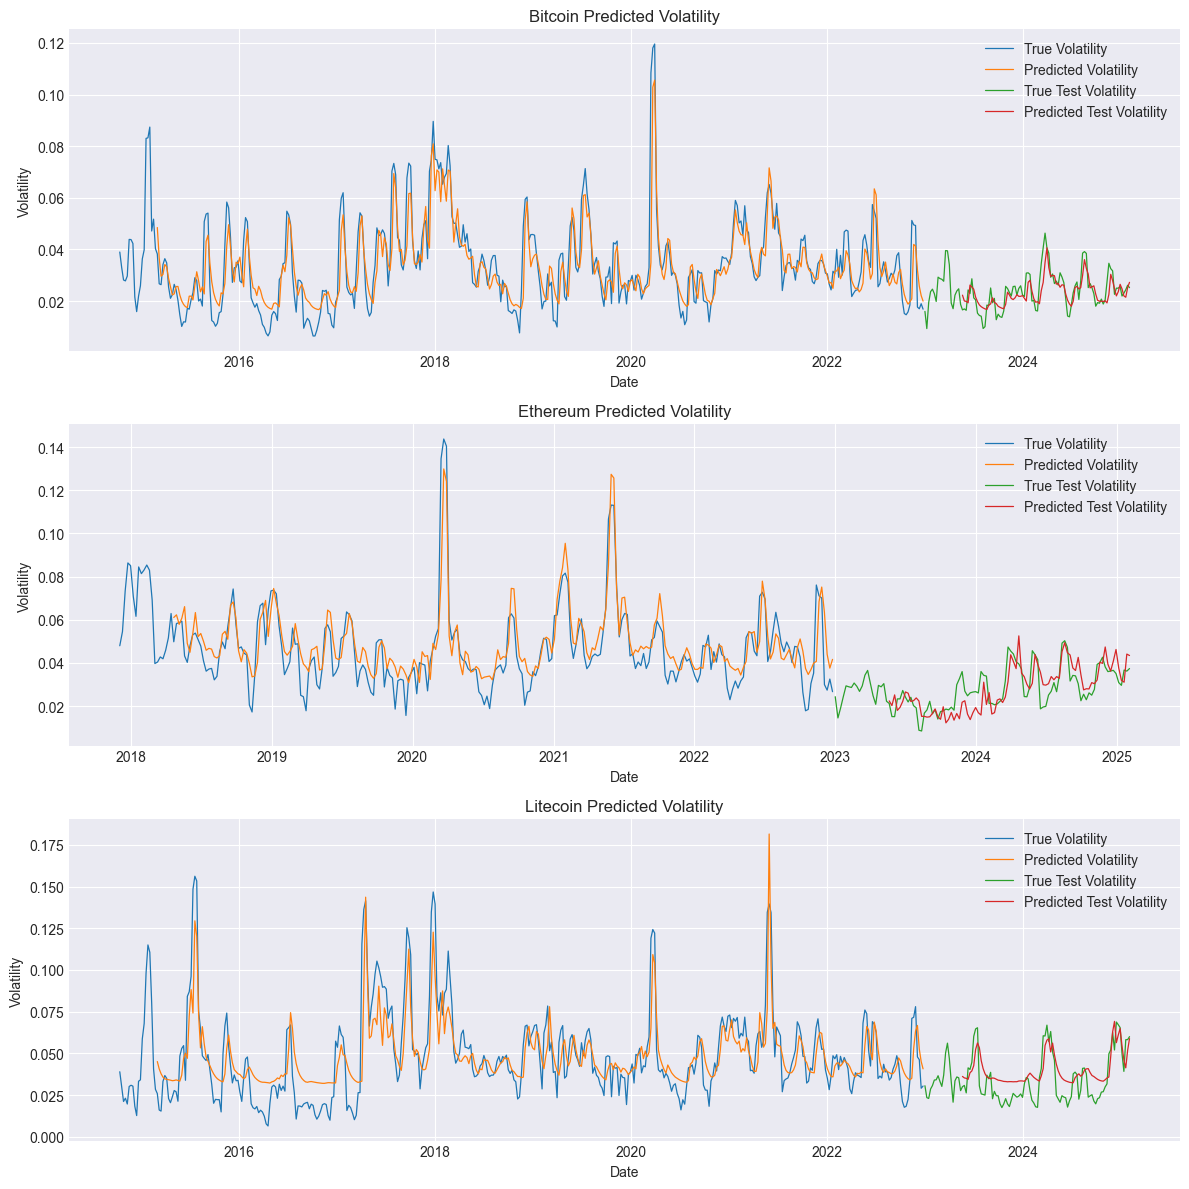

In [ ]:
def predict_and_plot(pipeline, train_data, test_data, ax, title):
    y_pred_train = pipeline.predict(train_data[features].values)
    y_pred_test = pipeline.predict(test_data[features].values)
    
    ax.plot(train_data.index, train_data["Volatility"], label="True Volatility", linewidth=0.9)
    ax.plot(train_data.index[-len(y_pred_train):], y_pred_train, label="Predicted Volatility",  linewidth=0.9)
    ax.plot(test_data.index, test_data["Volatility"], label="True Test Volatility",  linewidth=0.9)
    ax.plot(test_data.index[-len(y_pred_test):], y_pred_test, label="Predicted Test Volatility",  linewidth=0.9)
    ax.set_title(title)
    ax.set_xlabel("Date")
    ax.set_ylabel("Volatility")
    ax.legend()
    return y_pred_train, y_pred_test

fig, ax = plt.subplots(3, 1, figsize=(12, 12))

y_pred_bitcoin_train, y_pred_bitcoin_test = predict_and_plot(bitcoin_pipeline, bitcoin_train_weekly, bitcoin_test_weekly, ax[0], "Bitcoin Predicted Volatility")
y_pred_ethereum_train, y_pred_ethereum_test = predict_and_plot(ethereum_pipeline, ethereum_train_weekly, ethereum_test_weekly, ax[1], "Ethereum Predicted Volatility")
y_pred_litecoin_train, y_pred_litecoin_test = predict_and_plot(litecoin_pipeline, litecoin_train_weekly, litecoin_test_weekly, ax[2], "Litecoin Predicted Volatility")

plt.tight_layout()
plt.show()

## Monthly time step